In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

### SttCSVReader

In [7]:
from src import SttCSVReader, Draw_Reader_Event

In [8]:
# Input Data
input_dir = 'train_all'

In [9]:
# Event ID
event_id = 1

In [10]:
# Instantiate SttCSVReader Class
reader = SttCSVReader(input_dir,True,True)

In [11]:
# Read an Event
data = reader(event_id)

In [12]:
# data.hits.head()

In [13]:
# data.tubes.head()

In [14]:
# data.particles.head()

In [15]:
# data.truth.head()

In [16]:
# data.event_file

In [17]:
data.event.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,pdgcode,start_time,pt,peta,r,phi,eta,r3,absZ,tpt
0,1,-7.87217,14.645000,35.0,9,0,7,0.312154,0,0,...,-13,0,0.67161,-0.677819,16.626699,2.064018,1.489651,38.748512,35.0,0.666460
1,2,-8.74686,15.150000,35.0,9,1,112,0.243986,0,0,...,-13,0,0.67161,-0.677819,17.493713,2.094395,1.443957,39.128380,35.0,0.666533
2,3,-8.74686,16.160000,35.0,9,2,222,0.227273,0,0,...,-13,0,0.67161,-0.677819,18.375341,2.066909,1.400198,39.530407,35.0,0.666549
3,4,-9.62154,16.665001,35.0,9,3,339,0.326345,0,0,...,-13,0,0.67161,-0.677819,19.243084,2.094395,1.359552,39.941158,35.0,0.666467
4,5,-9.62154,17.674999,35.0,9,4,461,0.112023,0,0,...,-13,0,0.67161,-0.677819,20.124105,2.069298,1.320531,40.373005,35.0,0.666467


## _Detector Layout_

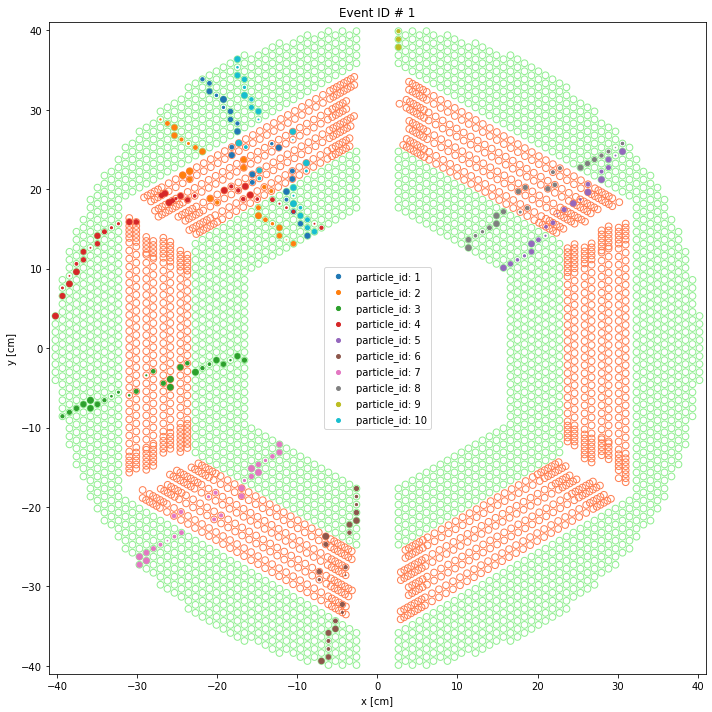

In [18]:
# Draw an Event from the Reader
Draw_Reader_Event(data, figsize=(10,10), save_fig=True);

### _Classifier Evaluation_

### _(+) - Test Dataset_

In [19]:
event_idx = 1

In [20]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [21]:
feature_data = torch.load(proc_files[event_idx], map_location=device)

### _(+) - Load Model_

In [22]:
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN

In [23]:
# path to config file
config_file = os.path.join(os.curdir, 'LightningModules/GNN/configs/train_quickstart_GNN.yaml')

In [24]:
# load config file (trusted source)
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [25]:
# see params used in this stage
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(config)

{ 'aggregation': 'sum_max',
  'callbacks': [['GNNTelemetry', 'GNNBuilder']],
  'cell_channels': 0,
  'datatype_names': [['train', 'val', 'test']],
  'datatype_split': [[800, 100, 100]],
  'edge_cut': 0.5,
  'emb_channels': 0,
  'factor': 0.3,
  'hidden': 128,
  'hidden_activation': 'ReLU',
  'input_dir': '${EXATRKX_DATA}/run/feature_store',
  'layernorm': True,
  'lr': 0.001,
  'max_epochs': 50,
  'n_graph_iters': 8,
  'nb_edge_layer': 3,
  'nb_node_layer': 3,
  'noise': False,
  'output_dir': '${EXATRKX_DATA}/run/gnn_evaluation',
  'overwrite': True,
  'patience': 10,
  'project': 'GNNStudy',
  'pt_background_min': 0.0,
  'pt_signal_min': 0.0,
  'regime': [['pid']],
  'spatial_channels': 3,
  'warmup': 200,
  'weight': 2}


In [26]:
# init the InteractionGNN
model = InteractionGNN(config)